<p style="color:#737373; font-family:futura; font-size:200%;">Cross-Current Heat Exchanger</p>
<p style="color:#737373; font-family:futura;">1 February 2021</p>

<p style="font-family:futura;">Schematic Representation</p>
<p style="font-family:futura;">The Boundary Value Problem</p>
Hot fluid:
$$\frac{dH^H}{dz} = - \frac{UP}{m_H} (T_H - T_C)\,\,; T_H(z=0) = T_H^{in}$$
Cold fluid:
$$\frac{dH^C}{dz} = - \frac{UP}{m_C} (T_H - T_C)\,\,; T_C(z=L) = T_C^{in}$$


* Add WATER data
* Add image
* Add proper source
* Alternative for interpolate
* Solve using solve_bvp
* Add ticks, labels and arrows
* get rid of this : <matplotlib.legend.Legend at 0x7f93fcd7a750>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.integrate
import scipy.interpolate
import scipy.optimize
from matplotlib import style

from IPython.display import display, Math
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['figure.figsize'] = [10,10]

style.use("classic")

<p style="font-family:futura;">List of compounds</p>

In [2]:
data = pd.read_csv("CpData.csv").replace(np.NaN, 0)
comp = data['Name']
MW = data['Mol. wt.']
Tmin = data['Tmin, K']
Tmax = data['Tmax, K']
C1 = data['C1']
C2 = data['C2']
C3 = data['C3']
C4 = data['C4']
C5 = data['C5']
print(np.array(comp))

['Acetaldehyde' 'Acetamide' 'Acetic acid' 'Acetic anhydride' 'Acetone'
 'Acetonitrile' 'Acetylene' 'Acrolein' 'Acrylic acid' 'Acrylonitrile'
 'Air' 'Anisole' 'Argon' 'Benzamide' 'Benzene' 'Benzene' 'Benzenethiol'
 'Benzoic acid' 'Benzonitrile' 'Benzyl ethyl ether' 'Benzyl mercaptan'
 'Biphenyl' 'Bromine' 'Bromobenzene' '1,2-Butadiene' '1,3-Butadiene'
 'Butane' '1-Butene' 'cis-2-Butene' 'trans-2-Butene' 'Butyl acetate'
 'sec-Butyl mercaptan' '1-Butyne' 'Butyraldehyde' 'Butyric acid'
 'Carbon disulfide' 'Carbon tetrachloride' 'Carbon tetrafluoride'
 'Chlorine' 'Chlorobenzene' 'Chloroethane' 'Chloroform' 'm-Cresol'
 'o-Cresol' 'p-Cresol' 'Cumene' 'Cyanogen' 'Cyclobutane' 'Cyclohexane'
 'Cyclohexanol' 'Cyclohexanone' 'Cyclopentene' 'Cyclopropane'
 'Cyclohexyl mercaptan' 'Decanal' 'Decane' 'Decyl mercaptan' '1-Decyne'
 '1,2-Dibromoethane' 'Dibromomethane' 'Dibutyl ether' 'm-Dichlorobenzene'
 'o-Dichlorobenzene' 'p-Dichlorobenzene' '1,1-Dichloroethane'
 '1,2-Dichloroethane' 'Dichloromethane'

In [3]:
compH = 'Ethylene glycol'    # HOT fluid
compC = 'Phthalic anhydride'    # COLD fluid

In [4]:
iH = comp.index[comp == compH].tolist()[0]
iC = comp.index[comp == compC].tolist()[0]

In [5]:
# Defining the enthalpy-temperature functions from Perry's Handbook
Tref = 293.15  # K

def H_H(T):  # T in K, H in J/kg
    return (C1[iH] * (T - Tref) + C2[iH] * (T ** 2 - Tref ** 2) / 2 +
            C3[iH] * (T ** 3 - Tref ** 3) / 3 + C4[iH] * (T ** 4 - Tref ** 4) / 4 +
            C5[iH] * (T ** 5 - Tref ** 5) / 5) / MW[iH]


def H_C(T):  # T in K, H in J/kg
    return (C1[iC] * (T - Tref) + C2[iC] * (T ** 2 - Tref ** 2) / 2 +
            C3[iC] * (T ** 3 - Tref ** 3) / 3 + C4[iC] * (T ** 4 - Tref ** 4) / 4 +
            C5[iC] * (T ** 5 - Tref ** 5) / 5) / MW[iC]


# Using linear interpolation to find temperature at a given enthalpy value

T = np.linspace(max(Tmin[iH], Tmin[iC]), min(Tmax[iH], Tmax[iC]), 500)
T_H = scipy.interpolate.UnivariateSpline(H_H(T), T, k=1, s=0)
T_C = scipy.interpolate.UnivariateSpline(H_C(T), T, k=1, s=0)

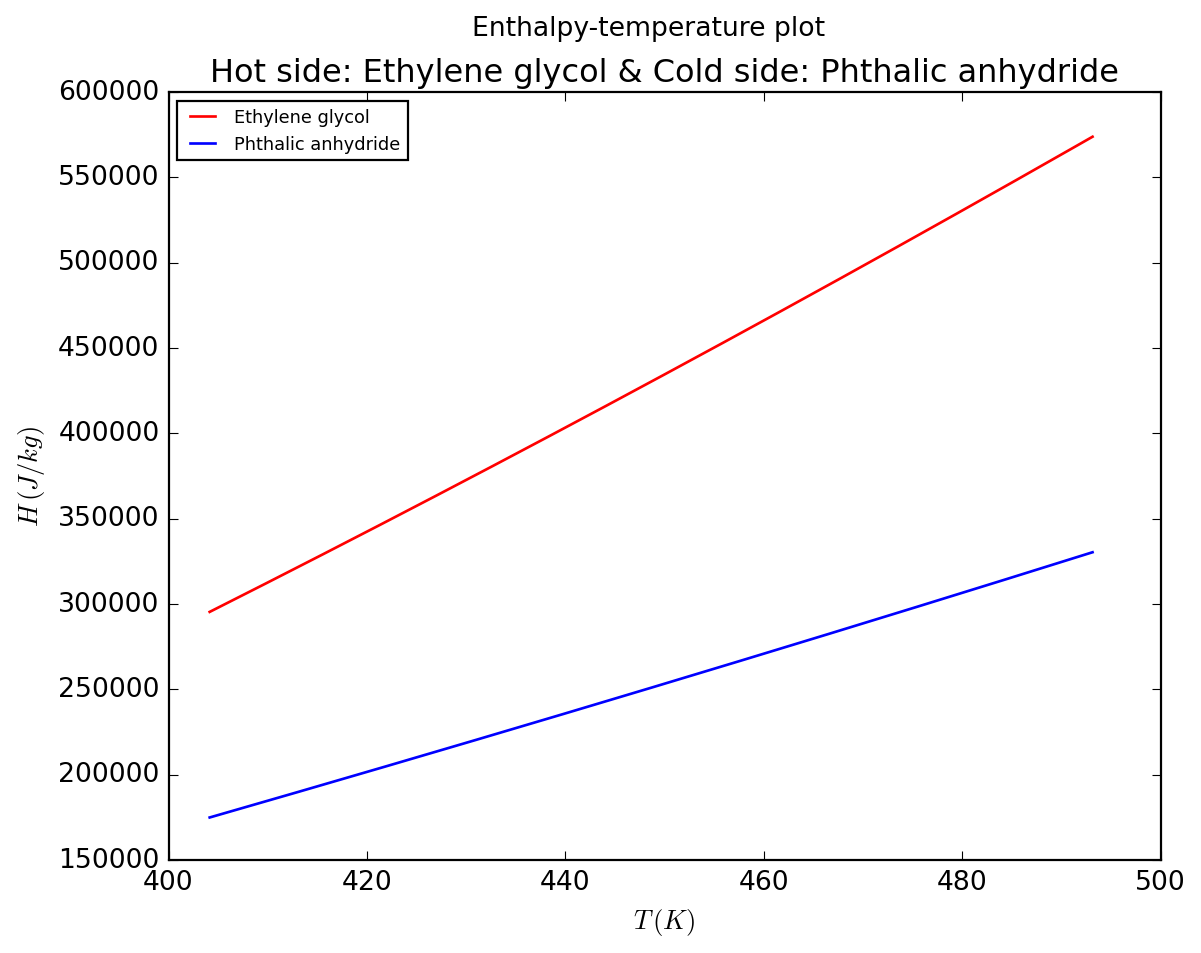

In [6]:
plt.figure(facecolor='white')
plt.suptitle("Enthalpy-temperature plot")
plt.title("Hot side: %s & Cold side: %s" % (compH, compC))
plt.plot(T, H_H(T), color='red', linewidth=1.2, label=compH)
plt.plot(T, H_C(T), color='blue', linewidth=1.2, label=compC)
plt.xlabel(r'$T\, (K)$')
plt.ylabel(r'$H\, (J/kg)$')
plt.legend(loc='best', fontsize=8);

In [7]:
# The system of ODEs are defined here

def model(H, z, heatx):
    [H_H, H_C] = H

    U = heatx.U
    P = heatx.P
    mH = heatx.mH
    mC = heatx.mC
    T_H = heatx.T_H(H_H)
    T_C = heatx.T_C(H_C)

    dH_Hdz = -U * P * (T_H - T_C) / mH
    dH_Cdz = -U * P * (T_H - T_C) / mC

    return [dH_Hdz, dH_Cdz]

<p style="font-family:futura;">Shooting Method</p>

In [8]:
# Shooting method for BVP 

def shoot(T_Cout, heatx):
    heatx.T_Cout = T_Cout

    H0 = [H_H(heatx.T_Hin), H_C(heatx.T_Cout)]
    z = [0, heatx.L]

    solution = scipy.integrate.odeint(model, H0, z, args=(heatx,))
    H_Cin = solution[-1, 1]
    T_Cin = heatx.T_C(H_Cin)

    error = [T_Cin - heatx.T_Cin]
    return error


class HeatX:
    def __init__(self):
        self.U = 400.0  # W/m2-K
        self.P = 0.1  # m2/m
        self.L = 1.0  # m

        self.mH = 0.01  # kg/s
        self.mC = 0.01  # kg/s
        self.T_Hin = 323.16  # K
        self.T_Cin = 303.16  # K

    def initialize(self):
        T = np.linspace(self.T_Cin, self.T_Hin, 1000)
        self.T_H = scipy.interpolate.UnivariateSpline(H_H(T), T, k=1, s=0)
        self.T_C = scipy.interpolate.UnivariateSpline(H_C(T), T, k=1, s=0)

    def solve(self, n=100):
        self.initialize()

        guess = [self.T_Cin + 0.0]

        lsq = scipy.optimize.least_squares(shoot, guess, args=(self,))

        H0 = [H_H(self.T_Hin), H_C(self.T_Cout)]
        z = np.linspace(0, self.L, n)

        solution = scipy.integrate.odeint(model, H0, z, args=(self,))
        H_Hsol = solution[:, 0]
        H_Csol = solution[:, 1]

        self.solutiondf = pd.DataFrame({"z": z,
                                        "T_H": self.T_H(H_Hsol),
                                        "T_C": self.T_C(H_Csol)})

In [9]:
heatx = HeatX()
heatx.solve()

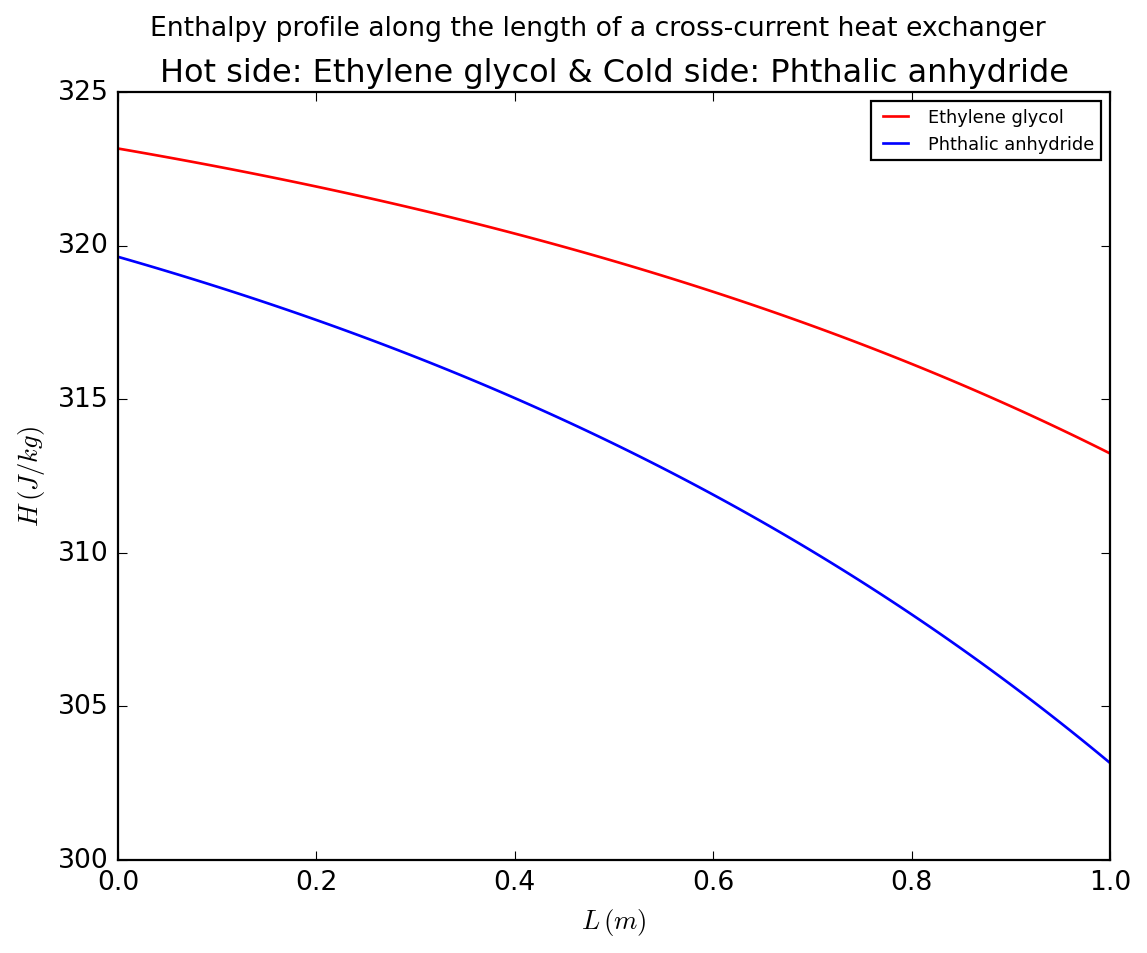

In [10]:
plt.figure(facecolor='white')
plt.suptitle("Enthalpy profile along the length of a cross-current heat exchanger")
plt.title("Hot side: %s & Cold side: %s" % (compH, compC))
plt.plot(heatx.solutiondf.z, heatx.solutiondf.T_H, color='red', linewidth=1.2, label=compH)
plt.plot(heatx.solutiondf.z, heatx.solutiondf.T_C, color='blue', linewidth=1.2, label=compC)
plt.xlabel(r'$L\, (m)$')
plt.ylabel(r'$H\, (J/kg)$')
plt.legend(loc='best', fontsize=8);

---
<p style="color:#737373; font-family:futura;">Source: Perry, R. H., &amp; Green, D. W. (2008). Physical and Chemical Data. In Perry's chemical engineers' handbook (pp. 165-170). McGraw Hill.</p>